In [1]:
import numpy as np
import time
import networkx as nx

import matplotlib.pyplot as plt

En esta sesión veremos algunos ejemplos de algoritmos (unos nuevos, y otros que ya hemos visto) y analizaremos sus complejidades, ya sea en tiempo, memoria o ambas.

# Preliminares

## Representación de enteros

En la gran mayoría de lenguajes de programación, los enteros son representados con un número fijo de bits. Esto significa que hay un límite superior e inferior a las cantidades que podemos expresar. Por ejemplo, para el tipo `int32` (enteros con signo de 32 bits), el rango de números válidos es:

$$
[-2^{31}, 2^{31}-1] = [-2\ 147\ 483\ 648, 2\ 147\ 483\ 647]
$$

Es importante notar que, bajo este esquema, todos los números ocupan el mismo espacio en memoria. Entonces, si queremos representar un 5 en `int32`, en realidad estamos guardando:

$$
5 = \underbrace{00000000000000000000000000000101}_\text{32 bits}
$$

---

Por alguna razón, los creadores de Python decidieron romper esta convención, y representar los enteros con un número *arbitrario* de bits. Esto significa que podemos expresar números tan grandes o tan pequeños como queramos, y Python asignará dinámicamente el número de bits necesario. A continuación, vemos algunos ejemplos de esto, utilizando el método `bit_length()` para obtener el número de bits:

In [2]:
enteros = [7, 15, 32, 1023, int(1e20)]
for i in enteros:
    print(f"Número de bits de {i}: {i.bit_length()}")

Número de bits de 7: 3
Número de bits de 15: 4
Número de bits de 32: 6
Número de bits de 1023: 10
Número de bits de 100000000000000000000: 67


Si bien esto sirve para ahorrar memoria para enteros menores a 32 bits, lo logra sacrificando las **operaciones en tiempo constante**. Como en `int32` (e `int16`, `int8`, etc.), todos los números tienen el mismo número de bits, las operaciones algebraicas tardan en esencia el mismo tiempo, por lo cual puede decirse que son $O(1)$ (**Nota:** Este tiempo depende del número de bits: por ejemplo, las operaciones en `int32` tardan más que en `int16`).

Sin embargo, como en Python el número de bits es variable, las operaciones ya no son de tiempo constante. Para números pequeños, Python utiliza el algoritmo de multiplicación que aprendemos en primaria, con una complejidad $O(n^2)$. Por otro lado, para números muy grandes, emplea el algoritmo de Karatsuba, con complejidad $\approx O\left(n^{1.58}\right)$.

Para ilustrar esto, definimos la siguiente función que calcula el factorial de `n`:

In [3]:
def my_fac(n):
    s = 1
    for i in range(1, int(n)+1):
        s *= i
    return s

Claramente, su complejidad es $O(n)$, por lo tanto, esperamos que su gráfica de tiempo vs. $n$ sea una línea recta. Sin embargo, ejecutándola para distintos valores de $n$ y midiendo su tiempo:

In [4]:
times = []
ns = np.logspace(1, 5, 15) # Nos regresa una sucesión de 15 números espaciados uniformemente en [10^1, 10^5]
#print(ns)
for n in ns:
    res = %timeit -o -q my_fac(n)
    times.append(res.average)

Graficando:

Text(0, 0.5, 'Tiempo (s)')

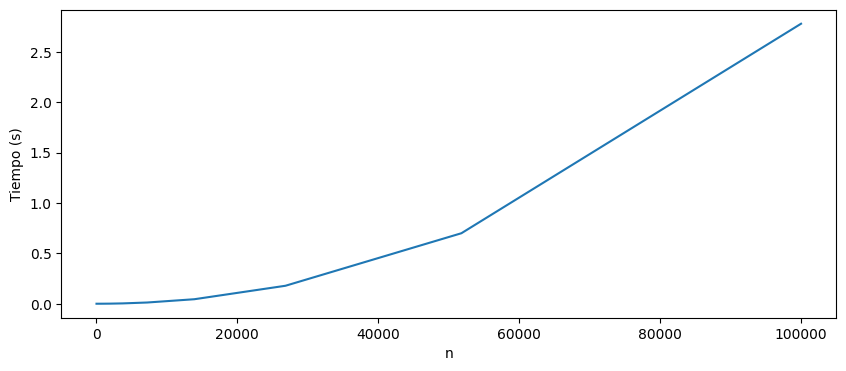

In [5]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(ns, times, label="Esperado")
ax.set_xlabel("n")
ax.set_ylabel("Tiempo (s)")

Dado que en las últimas partes, estamos obteniendo $100000!$ (que requiere de un total de 1516688 bits para poder representarse por completo), estas complejidades ya no son triviales.

---

En caso de que la precisión no sea tan importante, podemos solucionar este problema usando `float` en vez de `int`. Como `float` tiene un tamaño fijo de 64 bits, la multiplicación siempre toma un tiempo constante:

In [6]:
def my_fac_2(n):
    s = 1.0
    for i in range(1,int(n)+1):
        s *= i
    return s

In [7]:
times = []
ns = np.logspace(1, 5, 15)
for n in ns:
    res = %timeit -o -q my_fac_2(n)
    times.append(res.average)

Text(0, 0.5, 'Tiempo (s)')

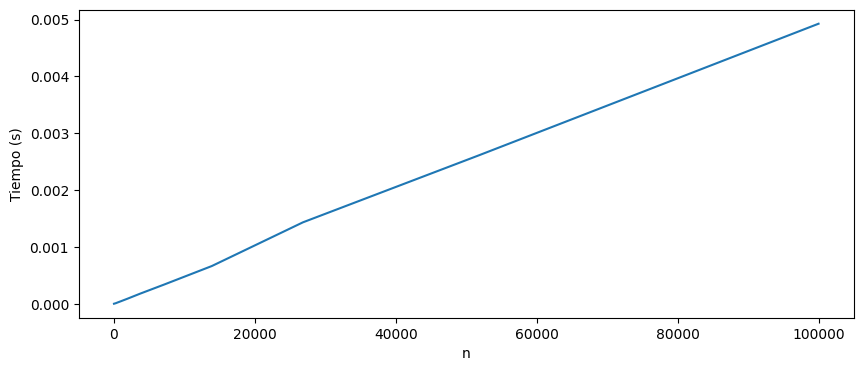

In [8]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(ns, times)
ax.set_xlabel("n")
ax.set_ylabel("Tiempo (s)")

## Pila de llamada

Python (y la mayoría de los lenguajes de programación) manejan lo que se conoce como una *pila de llamada* (en inglés *call stack*). Esta es  una estructura de datos de tipo LIFO (Last In First Out), en la cual se van colocando referencias a las funciones que vamos ejecutando. Cuando hacemos una llamada a una función, Python mete datos (variables, parámetros, punteros, etc.) a la pila; cuando la función termina de ejecutarse, la saca de la pila.

Ahora, supongamos que ejecutamos a la función `foo`. Después de iniciar, la pila se verá de la siguiente manera:

```
---
foo
---
```

Luego, si `foo` llama a la función `bar`, Python insertará la referencia correspondiente en la pila:

```
---
bar
---
foo
---
```

Cuando `bar` se acabe de ejecutar, saldrá de la pila:

```
---
foo
---
```

Y finalmente, `foo` termina, y sale de la pila:

```
---
---
```

---

¿Qué pasa cuando tenemos funciones *recursivas*? En este caso, Python insertará una referencia por cada una de las llamadas que hagamos. Por ejemplo, si tenemos la siguiente función para calcular el factorial de manera recursiva:

In [9]:
def fac(n):
    if n == 1:
        return 1
    return n * fac(n-1)

En total hará $n$ llamadas recursivas, por lo cual, al llegar a la última llamada (cuando $n=1$), la pila se verá de la siguiente manera:

```
---      --
fac<1>     \
---         \
fac<2>       \
---           \
fac<3>         n veces
---           /
...          /
---         /
fac<n>     /
---      --
```

Posteriormente, la función de hasta arriba ($n=1$) terminará y saldrá de la pila, seguida por la de abajo de ella, y así sucesivamente, hasta que se vacíe.

La complejidad de este algoritmo es:

* Tiempo: $O(n)$, ya que hacemos $n$ llamadas recursivas.
* Espacio: Como en la última llamada, la pila de llamadas tiene una altura $n$, la complejidad en espacio es $O(n)$, ya que la pila ocupa memoria física.

**Es importante tomar en cuenta la pila de llamadas cuando se analiza la complejidad en espacio.**

# Ejemplos

## Ejemplo 1

En la práctica de inducción, teníamos el siguiente problema:

Encuentra el valor de: 

$$\Big\lfloor \frac{1}{2}\Big \rfloor + \Big\lfloor \frac{2}{2}\Big \rfloor + \cdots + \Big\lfloor \frac{n}{2}\Big \rfloor$$

Este problema se puede resolver de forma sencilla utilizando un bucle `for`:

In [10]:
def floor_sum(n):
    s = 0
    for i in range(n+1):    # Se ejecuta n veces
        s += i//2           # Esta operación toma tiempo constante
    return s

* En tiempo, es $O(n)$, pues estamos haciendo $n$ operaciones, una en cada ciclo. 
* En memoria, es constante, pues lo único que tenemos que ir recordando es el valor de la suma en cada momento, es decir, es $O(1)$.

Nosotros habíamos encontrado una expresión cerrada para esta suma, con la cual podemos escribir otra función:

In [11]:
def floor_sum_2(n):
    return (n//2) * ((n+1)//2)

En este caso, la complejidad tanto en tiempo como en espacio es $O(1)$, ya que solo tenemos que realizar una operación sin importar el tamaño de la entrada.

## Ejemplo 2

Pasemos a un ejemplo más interesante. Supongamos que tenemos que diseñar un algoritmo tal que dado un entero positivo $n$ y un número real $x$, encuentre el valor de $x^n$, pero utilizando únicamente operaciones básicas (suma, resta, multiplicación y división).

Un primer algoritmo para hacer esto sería lo siguiente:

In [12]:
def potencia(x, n):
    p = x
    for i in range(2, n+1):
        p *= x
    return p

potencia(2,10)

1024

* En tiempo, nos toma $O(n)$, pues estamos iterando $n$ veces y en cada una hacemos una cantidad constante de operaciones.
* En memoria, es $O(1)$, pues sólo actualizamos el valor de $p$ en cada iteración. 

---

¿Cómo podemos optimizarlo? 

Notemos que si $n = 2k$, entonces: 

$$x^n = x^{2k}= (x^k)^2=x^kx^k$$ 

Por otro lado, si $n = 2k+1$, entonces: 

$$x^n = (x^k)^2 \cdot x$$ 

Usemos esto para obtener un algoritmo que sea mejor en cuanto a tiempo de ejecución:

In [13]:
def potencia_2(x, n):
    if n == 1:                  # Comparaciones toman tiempo constante
        return x
    
    p = potencia_2(x, n//2)     # ¿Cuántas veces se hace la llamada recursiva? 
    
    if n%2 == 0:                # Comparaciones toman tiempo constante
        return p*p              # Multiplicaciones toman tiempo constante
    else:
        return x*p*p            # Multiplicaciones toman tiempo constante

potencia_2(2, 10)

1024

La complejidad de este algoritmo es:

* **Tiempo:** En cada llamada recursiva, dividimos el exponente entre 2. Por lo tanto, tenemos en promedio un total de $\log_2(n)$ llamadas, en cada una de las cuales hacemos operaciones de tiempo constante. Por lo tanto, la complejidad en tiempo es $O(\log_2(n))$.
* **Espacio:** De nuevo, hacemos un total de $\log_2(n)$ llamadas recursivas. Por lo tanto, en su punto más alto, la pila de llamadas tendrá  este tamaño, de lo cual se sigue que la complejidad en espacio es $O(\log_2(n))$.

## Ejemplo 3

Digamos que queremos calcular el $n$-ésimo valor de la sucesión de Fibonacci, i.e., $F_n$.

Una primera opción sería haciéndolo de manera recursiva:

In [14]:
def fib(n):
    if n == 0:
        return 0
    if n == 1:
        return 1
    return fib(n-1) + fib(n-2)

fib(8)

21

La complejidad de este algoritmo es:

* **Tiempo:** Como para cada $n > 1$, requerimos llamar a la función `fib` dos veces, se concluye que la complejidad en tiempo es $O(2^n)$.
* **Espacio:** La pila de recursión tiene como altura máxima $n$; por lo tanto, la complejidad en espacio es $O(n)$.

---

¿Qué pasa si guardamos los valores de los números de Fibonacci que vamos calculando? Es decir, guardamos el valor de $F_k$ la primera vez que llamemos a $fib(k)$.

In [15]:
def fib2(k, Fs=None):
    if Fs is None:
        Fs = [None] * (k+1)

    if k == 0:
        return 0
    elif k == 1:
        return 1
    
    if Fs[k] is not None:           # Si ya calculamos el valor fib(k), entonces no necesitamos calcularlo de nuevo
        return Fs[k]
    else:
        Fs[k] = fib2(k-1, Fs=Fs) + fib2(k-2, Fs=Fs) 
        return Fs[k]

print(fib2(8))

t = %timeit -o -q fib2(2500)
t

21


<TimeitResult : 1.1 ms ± 28.5 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)>

La complejidad de este algoritmo es:

* **Tiempo:** La complejidad en tiempo mejora considerablemente, ya que `fib(k)` solo llama a `fib(k-1)` y `fib(k-2)` una vez, y todas las demás veces simplemente se accesa el valor guardado. Dado que se tienen que hacer $n$ llamadas como mínimo, se concluye que la complejidad en tiempo es $O(n)$.
* **Espacio:** La altura máxima de la pila de llamadas no cambia. Adicionalmente, estamos guardando un arreglo de tamaño $n+1$ en la memoria, por lo cual la complejidad es $O(n) + O(n) = O(n)$.

A esta técnica de guardar los resultados de una función para utilizarlos después se le conoce como **memorización**, y la veremos con más detalle en libretas siguientes.


Otra técnica de optimización en funciones recursivas es la llamada recursión de cola (del inglés, tail recursion). En este tipo de recursión, lo que se hace es realizar la recursión como el último cómputo de la función recursiva.

In [16]:
def fib3(n, fib1 = 0, fib2 = 1):
    if n == 0:
        return fib1
    return fib3(n-1,  fib2, fib1+fib2)

t = %timeit -o -q fib3(2500)
t

<TimeitResult : 648 μs ± 47.2 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)>

La complejidad de este algoritmo es:

* **Tiempo:** Dado que se tienen que hacer $n$ llamadas recursivas, se concluye que la complejidad en tiempo es $O(n)$.
* **Espacio:** La altura de la pila siempre es 1, y no se hace uso de ninguna estructura de datos, por lo que la complejidad en espacio es $O(1)$.

A esta técnica de guardar los resultados de una función para utilizarlos después se le conoce como **memorización**, y la veremos con más detalle en libretas siguientes.

Estas funciones nos permiten encontrar el valor de $F_n$ de manera recursiva. Alternativamente, podemos escribir una que lo haga de manera iterativa:

In [17]:
def fib4(n):
    if n == 0:
        return 0
    elif n == 1:
        return 1
    
    count = 1
    k1 = 0
    k2 = 1
    while count != n:
        k1, k2 = k2, k1 + k2
        count += 1
    return k2

fib3(8)

t = %timeit -o -q fib4(2500)
t

<TimeitResult : 273 μs ± 31.6 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)>

* **Tiempo:** $O(n)$, ya que hacemos $n$ iteraciones del bucle `while`.
* **Espacio:** $O(1)$, ya que las únicas variables que guardamos son `count, k1, k2`

Esto nos muestra algo que también es bastante común, hacer un algoritmo de forma iterativa suele hacerlo más eficiente, ya sea en espacio, en tiempo o ambas. Sin embargo, muchas veces es muy complicado pasar de algo recursivo a algo iterativo.

## Ejemplo 4

Analicemos las complejidades de el algoritmo de DFS, que vimos anteriormente.

[(0, 1), (0, 5), (0, 7), (1, 2), (1, 4), (1, 5), (2, 5), (3, 4), (3, 5), (4, 5), (4, 6), (5, 7)] 



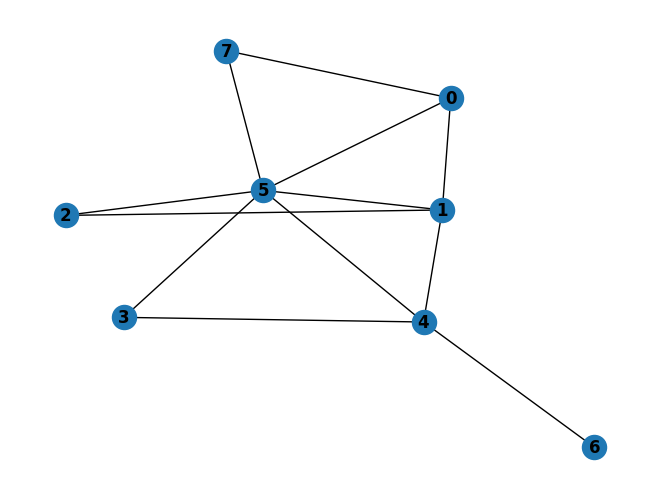

In [18]:
n = 8
p = 1/3

G = nx.gnp_random_graph(n, p)
print(G.edges, '\n')
nx.draw(G, with_labels=True, font_weight='bold')

In [19]:
def dfs(g, v, visited=None):
    if visited is None:
        visited = [False] * len(g.nodes)
        
    visited[v] = True
    print(v) # Aquí puede ir cualquier otra cosa
    for u in g.adj[v]:
        if not visited[u]:
            dfs(g, u, visited)
            
dfs(G, 0)

0
1
2
5
3
4
6
7


Antes de iniciar el análisis, es importante entender cómo se representan las gráficas en las computadoras. Por ejemplo, tomemos la siguiente gráfica de ejemplo:

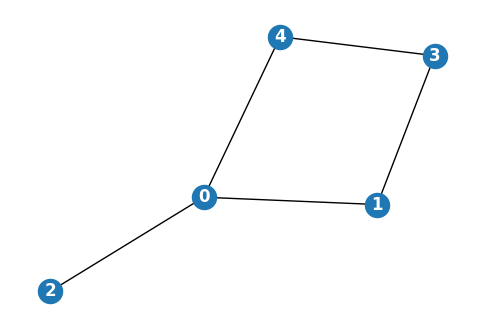

In [20]:
g = nx.Graph()
g.add_nodes_from([0, 1, 2, 3, 4])
g.add_edges_from([(0, 1), (0, 2), (0, 4), (1, 3), (3, 4)])

fig, ax = plt.subplots(figsize=(6, 4))
nx.draw(g, with_labels=True, font_weight="bold", font_color="white", ax=ax)

**Matriz de adyacencia**

La gráfica se representa como una matriz de $n\times n$. La entrada $(i, j)$ es 1 si existe una arista de $i$ a $j$, y 0 en otro caso. En caso de una gráfica no dirigida, la matriz es simétrica (i.e., tanto $(i, j)$ como $(j, i)$ es 1 si existe una arista).

Para nuestra gráfica de ejemplo, la matriz de adyacencia es:

$$
\begin{pmatrix}
0 & 1 & 1 & 0 & 1 \\
1 & 0 & 0 & 1 & 0 \\
1 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 1 \\
1 & 0 & 0 & 1 & 0 \\
\end{pmatrix}
$$

**Lista de adyacencia**

En este caso, la gráfica se representa como una lista de longitud $n$. La $i$-ésima entrada de la lista contiene todos los vértices a los cuales es adyacente el vértice $i$.

Entonces, para nuestra gráfica de ejemplo, la lista de adyacencia es:

```
0: 1, 2, 4
1: 0, 3
2: 0
3: 1, 4
4: 0, 3
```

---

¿Cómo influye esto en la complejidad del algoritmo?

Analicemos los casos por separado. Es importante recordar que estamos estudiando el algoritmo, por lo cual **no** debemos de considerar el espacio ocupado por la representación de la gráfica.

### Matriz de adyacencia

* **Tiempo:** Para obtener todos los vecinos de un nodo, tenemos que revisar cada entrada de la fila correspondiente de la matriz de adyacencia, lo cual toma tiempo $O(n)$. Como tenemos que hacer esto para todos los nodos, concluimos que la complejidad en tiempo es $O(n^2)$.
* **Espacio:** En el peor de los casos, haremos $n$ llamadas recursivas anidadas. Por lo tanto, la altura máxima de la pila de llamadas es $n$, y la complejidad en espacio es $O(n)$.

### Lista de adyacencia

* **Tiempo:** Para obtener todos los vecinos de un nodo, tenemos que accesar la correspondiente entrada en la lista de adyacencia, y revisar todos los nodos listados. Al finalizar el algoritmo, habremos accesado las $n$ entradas, y revisado los $m$ nodos listados. Por lo tanto, la complejidad en tiempo es $O(n+m)$.

Es importante notar que, para una gráfica no-dirigida, accesaremos cada arista dos veces; por lo tanto, la complejidad es $O(n+2m)\sim O(n+m)$.

* **Espacio:** Por el mismo argumento que en el caso anterior, tenemos que la complejidad en espacio es $O(n)$.

# Ejercicios

## Ejercicio 1

Como notamos en clase, la representación de matriz de adyacencia y lista de adyacencia es redundante para gráficas no-dirigidas. En el caso de la matriz de adyacencia, la siguiente matriz es equivalente a la de nuestro ejemplo:

$$
\begin{pmatrix}
0 & & & & \\
1 & 0 & & & \\
1 & 0 & 0 & & \\
0 & 1 & 0 & 0 & \\
1 & 0 & 0 & 1 & 0 \\
\end{pmatrix}
$$

Análogamente, nuestra lista de adyacencia puede reducirse a la siguiente forma:

```
0: 1, 2, 4
1: 3
2: 
3: 4
4: 
```

---

Asumiendo que tenemos estas representaciones para una gráfica en general, explica cómo cambiaría (si es que lo hace) la complejidad en tiempo y espacio del algoritmo DFS.

### **Análisis de complejidad**
**1. Matriz de adyacencia**

**Tiempo**: Como la matriz es tamaño $n \times n$ (en este caso $5 \times 5$), aún se deben revisar las $n$ entradas de cada fila, ya que no podemos omitir la revisión de entradas vacías en la matriz.

Al hacer esto para cada uno de los $n$ nodos, la complejidad total sigue siendo:
$$O(n^2)$$
Aunque algunas posiciones en la matriz estén vacías, el tiempo requerido para recorrer cada fila no se ve afectado significativamente en términos asintóticos.

**Espacio**: El espacio en la pila de recursión del DFS sigue siendo el mismo que antes, ya que el número de nodos no ha cambiado. En el peor de los casos, la pila de llamadas del DFS puede crecer hasta una profundidad de $n$, por lo tanto:
$$O(n)$$

**2. Lista de adyacencia**

**Tiempo**: En la lista de adyacencia, solo se recorren los vecinos explícitamente listados para cada nodo. Aquí observamos que el número de aristas $m$ ha disminuido, ya que algunos nodos no tienen vecinos.

En la implementación de lista de adyacencia vista en el ejemplo, notamos que accesamos a cada arista dos veces; por lo tanto, la complejidad es $O(n+2m)\sim O(n+m)$; por el contrario, en esta implementación de lista de adyacencia, eliminamos "las aristas duplicadas", entonces, el DFS recorrerá $n$ nodos y $m$ aristas, lo que resulta en una compejidad de: $$O(n+m)$$

Para este caso, $n=5$ y el número de aristas es $m=5$. Su complejidad, en este caso específico, sería $O(5+5)=O(10)$, que sigue siendo lineal con respecto a $n+m$.

**Espacio**: Es similar al caso de la matriz de adyacencia, la pila de recursión del DFS puede crecer hasta una profundidad de $n$, por lo que la complejidad en espacio también es:
$$O(n)$$

## Ejercicio 2

Podemos definir el máximo común divisor de $a$ y $b$ de manera recursiva de la siguiente manera:

$$
\text{mcd}(a, b) = 
\begin{cases}
a, & \text{si}\ b=0 \\
\text{mcd}(b, a\mod b), & \text{en otro caso} 
\end{cases}
$$

Escribe una función que utilice esta definición para calcular el MCD de manera recursiva. Posteriormente, escribe otra que lo haga de manera iterativa. Explica la complejidad en tiempo y espacio de ambas.

#### Versión recursiva

In [21]:
def mcd_recursivo(a, b):
    if b == 0:
        return a
    else:
        return mcd_recursivo(b, a % b)

In [22]:
print(mcd_recursivo(12, 8)) # 4
print(mcd_recursivo(15, 20)) # 5

4
5


**Análisis de complejidad**

**Tiempo:** La función realiza una llamada recursiva con $b$ y $a$ y $\text{mod }b$, y este proceso se repite hasta que $b=0$, lo cual tiene una complejidad en tiempo de:
$$O(\log(\text{min}(a,b)))$$

**Espacio:** Esta versión almacena cada llamada en la pila de recursión. Como el número de llamadas recursivas en espacio debido a la pila es:
$$O(\log(\text{min}(a,b)))$$

#### Versión iterativa

In [23]:
def mcd_iterativo(a, b):
    while b != 0:
        a, b = b, a % b
    return a

In [24]:
print(mcd_iterativo(12, 8)) # 4
print(mcd_iterativo(15, 20)) # 5

4
5


**Análisis de complejidad**

**Tiempo:** De manera análoga a la versión recursiva, el bucle `while` termina hasta que $b=0$, y se requieren $O(\log(\text{min}(a,b)))$ divisiones, por lo tanto, su complejidad en tiempo también es:
$$O(\log(\text{min}(a,b)))$$

**Espacio:** Esta versión no utiliza la pila de llamadas, solo variables locales dentro de un bucle. Por lo tanto, su complejidad en espacio es constante:
$$O(1)$$

## Ejercicio 3

Escribe una función recursiva que determine si un *string* dado es un palíndromo o no. Luego, haz lo mismo de manera iterativa. Analiza la complejidad en tiempo y espacio de ambas.

#### Versión recursiva

In [25]:
def es_palindromo_recursivo(s):
    s = s.replace(' ', '').lower()
    if len(s) <= 1:
        return True
    elif s[0] == s[-1]:
        return es_palindromo_recursivo(s[1:-1])
    else:
        return False

In [26]:
print(es_palindromo_recursivo("Anita lava la tina")) # True
print(es_palindromo_recursivo("RECONOCER")) # True
print(es_palindromo_recursivo("Hola mundo")) # False

True
True
False


**Análisis de complejidad**

**Tiempo:** La función hace una llamada recursiva en cada paso, comparando el primer y el último caracter y quitando dos caracteres al *string*. Esto ocurre hasta que el tamaño del *string* sea 0 o 1. Dado que el tamaño del *string* se reduce en 2 en cada llamada, el npumero de llamadas es aproximadamente $O(\frac{n}{2}) \sim O(n)$. Por lo tanto, su complejidad temporal es:
$$O(n)$$

**Espacio:** Cada llamada recursiva se agrega a la pila de recursión, y dado que se hacen $O(\frac{n}{2})$ llamadas recursivas, la complejidad espacial es: 
$$O(n)$$

#### Versión iterativa

In [27]:
def es_palindromo_iterativo(s):
    s = s.replace(' ', '').lower()
    i, j = 0, len(s) - 1
    while i < j:
        if s[i] != s[j]:
            return False
        i += 1
        j -= 1
    return True

In [28]:
print(es_palindromo_recursivo("Anita lava la tina")) # True
print(es_palindromo_recursivo("RECONOCER")) # True
print(es_palindromo_recursivo("Hola mundo")) # False

True
True
False


**Análisis de complejidad**

**Tiempo:** Esta versión compara el primer y el último caracter en cada iteración, los dos iteradores van avanzando hacia el centro del *string*, realizando $O(\frac{n}{2})$ operaciones, lo que es equivalente a:
$$O(n)$$

**Espacio:** La versión iterativa utiliza dos variables (iteradores) y no hace llamas adicionales; por lo tanto, su complejidad espacial es constante:
$$O(1)$$